In [1]:
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '2,7'

In [ ]:
from src.ScoreBasedInferenceModel import ScoreBasedInferenceModel as SBIm
from src.plot_functions import *

import matplotlib.pyplot as plt
import matplotlib.animation
import matplotlib.patches as patches
import seaborn as sns

import numpy as np
import torch
from torch.distributions.normal import Normal
from torch.distributions.uniform import Uniform

from scipy.stats import norm

import os
import time as t

from Chempy.parameter import ModelParameters

%matplotlib inline
%load_ext line_profiler

In [3]:
# ----- Load the data -----
a = ModelParameters()
labels = [a.to_optimize[i] for i in range(len(a.to_optimize))] + ['time']
priors = torch.tensor([[a.priors[opt][0], a.priors[opt][1]] for opt in a.to_optimize])

elements = a.elements_to_trace

In [ ]:
model = SBIm.load('data/models/optuna_113/Model_checkpoint.pt')
device = "cuda"

In [5]:
# ----- Load the NN -----
class Model_Torch(torch.nn.Module):
    def __init__(self):
        super(Model_Torch, self).__init__()
        self.l1 = torch.nn.Linear(len(labels), 100)
        self.l2 = torch.nn.Linear(100, 40)
        self.l3 = torch.nn.Linear(40, len(elements))

    def forward(self, x):
        x = torch.tanh(self.l1(x))
        x = torch.tanh(self.l2(x))
        x = self.l3(x)
        return x
    
emulator = Model_Torch()
emulator.load_state_dict(torch.load('data/models/pytorch_state_dict_5sigma_uni_prior.pt'))
emulator.eval();

# Simulate data
With the set global priors and for each $N_{\rm stars}$ a set of local priors, we can simulate the data with the Neural Network.

In [6]:
N_stars = 200
simulations = 1000

stars = torch.stack([p.sample_n(N_stars) for p in [Normal(p[0]*torch.ones(1), p[1]*torch.ones(1)) for p in priors[2:]]+[Uniform(torch.tensor([2.0]), torch.tensor([12.8]))]], dim=0).squeeze().T
global_params = torch.tensor([[-2.3, -2.89]])

stars = torch.cat((global_params.repeat(N_stars, 1), stars), dim=1)

/export/home/bguenes/anaconda3/envs/simformer_torch/lib/python3.10/site-packages/torch/distributions/distribution.py:179: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn(


In [7]:
# ----- Simulate abundances -----
start = t.time()
abundances = emulator(stars)  
# Remove H from data, because it is just used for normalization (output with index 2)
abundances = torch.cat([abundances[:,0:2], abundances[:,3:]], axis=1)
end = t.time()
print(f'Time to create data for {N_stars} stars: {end-start:.3f} s')

Time to create data for 200 stars: 0.004 s


# SBI with 5% observation error noise
Need to load the posterior trained with a 5% observation error

In [8]:
def add_noise(true_abundances):
    # Define observational erorrs
    pc_ab = 5 # percentage error in abundance

    # Jitter true abundances and birth-times by these errors to create mock observational values.
    obs_ab_errors = np.ones_like(true_abundances)*float(pc_ab)/100.
    obs_abundances = norm.rvs(loc=true_abundances,scale=obs_ab_errors)

    return obs_abundances

In [17]:
alpha_IMF_obs = []
log10_N_Ia_obs = []
simulations = 1000

mask = torch.zeros(14)
mask[6:] = 1

start = t.time()

x = torch.tensor(add_noise(abundances.detach().numpy()), dtype=torch.float32)
inference = model.sample(x, condition_mask=mask, device=device, num_samples=simulations, timesteps=1000, method="dpm",multi_obs_inference=True, hierarchy=[0,1], save_trajectory=True)

end = t.time()
print(f'Time to run {simulations} simulations for {N_stars} stars: {end-start:.3f} s')

100%|██████████| 999/999 [08:20<00:00,  2.00it/s]


Time to run 1000 simulations for 200 stars: 509.503 s


In [18]:
alpha_IMF_obs, log10_N_Ia_obs = inference[:,:,:2].cpu().T.detach().numpy()

alpha_IMF_obs = alpha_IMF_obs.T
log10_N_Ia_obs = log10_N_Ia_obs.T

In [19]:
alpha_mean = alpha_IMF_obs.mean()
alpha_std = alpha_IMF_obs.std()

logN_Ia_mean = log10_N_Ia_obs.mean()
logN_Ia_std = log10_N_Ia_obs.std()

print(f'alpha_IMF: {alpha_mean:.3f} +- {alpha_std:.3f}')
print(f"True: {global_params[0,0]:.3f}")
print()
print(f'log10_N_Ia: {logN_Ia_mean:.3f} +- {logN_Ia_std:.3f}')
print(f"True: {global_params[0,1]:.3f}")


alpha_IMF: -13.275 +- 15.518
True: -2.300

log10_N_Ia: -12.470 +- 15.517
True: -2.890


In [12]:
inference.T.flatten(1).mean(1)

tensor([-16.2617, -15.9615,  -0.0664,   0.5438,   0.4865,   3.5418,   0.0535,
         -0.1064,   0.1261,   0.2822,   0.0879,   0.5666,   0.3851,   0.2498])

In [13]:
inference.T.flatten(1).std(1)

tensor([24.0559, 26.1159,  0.1366,  0.0326,  0.0389,  1.0784,  0.0681,  0.2963,
         0.2702,  0.0960,  0.0744,  0.0864,  0.1146,  0.1003])

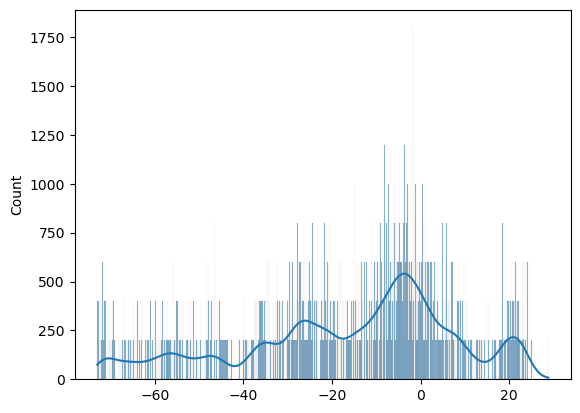

In [14]:
ax = sns.histplot(alpha_IMF_obs.flatten(), bins=1000, kde=True)
plt.show()

In [15]:
ax.lines[0].get_xdata()[np.argmax(ax.lines[0].get_ydata())]

-3.922543865951468

In [16]:
x = np.arange(0,model.multi_obs_sampler.data_t[0,:,:,0].shape[0]-1)
y = model.multi_obs_sampler.data_t[0,:-1,:,0].detach().numpy().mean(axis=1)
yerr = model.multi_obs_sampler.data_t[0,:-1,:,0].detach().numpy().std(axis=1)

plt.plot(x,y)
plt.fill_between(x, y-yerr, y+yerr, alpha=0.5)
plt.hlines(-2.3, 0, model.multi_obs_sampler.data_t[0,:,:,0].shape[0]-1, color='red')
plt.title(r"$\alpha_{IMF}$")
plt.show()

AttributeError: 'MultiObsSampler' object has no attribute 'data_t'

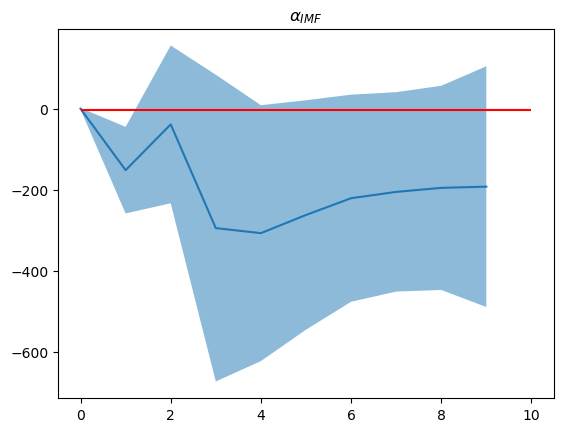

In [ ]:
x = np.arange(0,model.multi_obs_sampler.data_t[0,:,:,1].shape[0]-1)
y = model.multi_obs_sampler.data_t[0,:-1,:,1].detach().numpy().mean(axis=1)
yerr = model.multi_obs_sampler.data_t[0,:-1,:,1].detach().numpy().std(axis=1)

plt.plot(x,y)
plt.fill_between(x, y-yerr, y+yerr, alpha=0.5)
plt.hlines(-2.89, 0, model.multi_obs_sampler.data_t[0,:,:,1].shape[0]-1, color='red')
plt.title(r"$\alpha_{IMF}$")
plt.show()